In [1]:
#Import libraries
import cv2
from numpy import dtype
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFilter
from skimage.measure import profile_line
from skimage import io
from scipy.ndimage.filters import gaussian_filter1d
from scipy.stats import norm
from scipy.optimize import curve_fit
import sys 
from scipy.interpolate import griddata
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage import uniform_filter1d



import os



%matplotlib inline

C:\Users\valmu\AppData\Local\Temp\ipykernel_24816\3088558683.py:10: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


# MTV DATA PROCESSING CODE PARTE 2

## Variables

In [2]:
# List of all the variables 


"""
img =          # path of the image read by python
width =        # width of the image 
height =       # height of the image
min =           # starting point of the pixel  
min_int =        # minimim intensity for plotting the subpixel fit 
step = 30     #
start = 0     #
band =       # how many points do you want to grab for the interpolation/fit 
line =      # on which row of pixel do you want to take the profile from
ver =       # width of pixels aproximately of the wall 
ver_int =       # minimal intensity for detecting the wall
thick =         # estimation of width the excited particles and wall take.
degree =         # degree of fit for the points that trace the beam 

"""


'\nimg =          # path of the image read by python\nwidth =        # width of the image \nheight =       # height of the image\nmin =           # starting point of the pixel  \nmin_int =        # minimim intensity for plotting the subpixel fit \nstep = 30     #\nstart = 0     #\nband =       # how many points do you want to grab for the interpolation/fit \nline =      # on which row of pixel do you want to take the profile from\nver =       # width of pixels aproximately of the wall \nver_int =       # minimal intensity for detecting the wall\nthick =         # estimation of width the excited particles and wall take.\ndegree =         # degree of fit for the points that trace the beam \n\n'

## Preprocess

OG image type:uint16
OG image Shape: (2000, 1500)


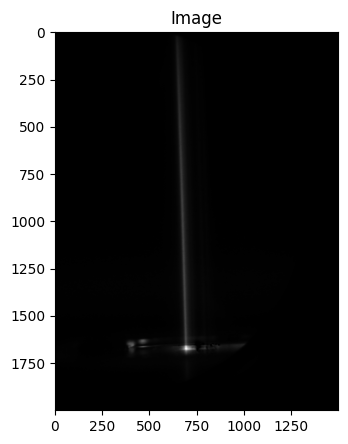

In [3]:
# Read image

img = cv2.imread(r"C:\Users\valmu\OneDrive\Val\Documents\GWU\Internships\RESEARCH\Valeria\average_bp_ws30dt00.tif",cv2.IMREAD_UNCHANGED)  
img0 = cv2.imread(r"C:\Users\valmu\OneDrive\Val\Documents\GWU\Internships\RESEARCH\Valeria\bp_ws30_dt050_0160.tif",cv2.IMREAD_UNCHANGED)  

# Display info of image
print(f"OG image type:{img.dtype}")
print(f"OG image Shape: {img.shape}")

#gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# Display Images 

fig = plt.figure(figsize=(30, 20))  # create a figure
fig.add_subplot(3, 7, 1)  # Position and size
pyplot.imshow(img, cmap="gray")
plt.title("Image") ; # Title of figure


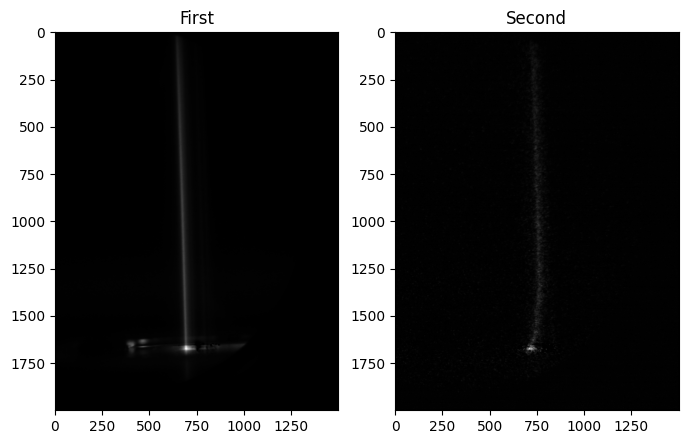

In [4]:
# Display both images
fig = plt.figure(figsize=(30, 20))  # create a figure
fig.add_subplot(3, 7, 1)  # Position and size
pyplot.imshow(img, cmap="gray")
plt.title("First")  # Title of figure
fig.add_subplot(3, 7, 2)
pyplot.imshow(img0, cmap="gray")
plt.title("Second");


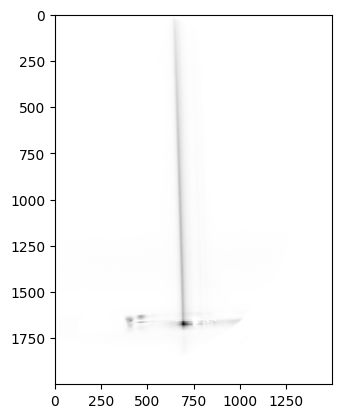

In [5]:
# If intensity of image is inversed 

img_rever =  cv2.bitwise_not(img)
plt.imshow(img_rever, cmap='gray' )


## Image Processing

#### Crop Image

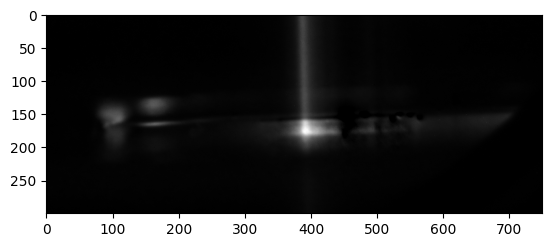

In [6]:
# Crop image, to just use the most important part of the picture 
y = 1500
h = 300
x =300
w =750
crop_img = img[y:y+h, x:x+w]
plt.imshow(crop_img, cmap='gray')


#### Improve Resolution    

In [7]:
# Denoising the image
#img_denoised = cv2.fastNlMeansDenoising(img, None, 20, 7, 21, normType=cv2.NORM_L1 ) ;
#img0= cv2.fastNlMeansDenoising(img0, None, 20, 7, 21) ;






#### Intensity Profile

11


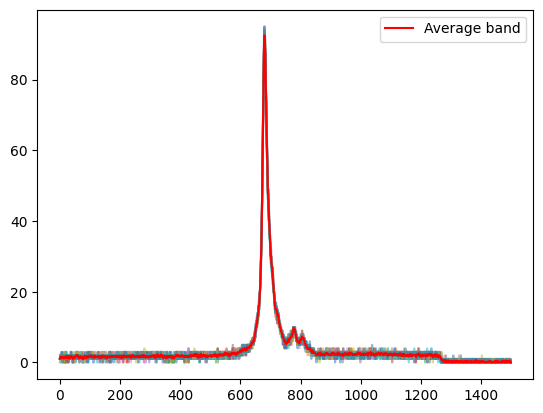

In [8]:

# Compute profile of multiple rows 
line = 1230
band =10
start = (line, 0) #Start of the profile line row=100, col=0
end = (line, img.shape[1] - 1) #End of the profile line row=100, col=last
profile = profile_line(img, start, end, linewidth=band)

# Average the profile line 
profiles = []

for offset in np.arange(0, band + 1 ):     # grabs the rows below a specific lien 
    start_row = line + offset
    end_row = line + offset
    start = (start_row, 0)
    end = (end_row, img.shape[1] - 1)
    
    # Ensure that the start and end rows are within the image boundaries
    if 0 <= start_row < img.shape[0]:
        # Extract the profile line for the current row offset
        profile = profile_line(img, start, end)
        profiles.append(profile)

# Convert the list of profiles to a NumPy array for easy averaging
profiles = np.array(profiles)

print(len(profiles))

# Compute the average profile
average_profile = np.mean(profiles, axis=0)

# Smooth the average profile
smoothing_window = 5 

smoothed_average_profile = uniform_filter1d(average_profile, size=smoothing_window)

# Find peak 

peak  = np.max(smoothed_average_profile)
idx = np.where(smoothed_average_profile==peak)

# Check if average array is actualy the average 

for profile in profiles :  #
    plt.plot(profile, alpha=0.5)

#plt.plot(smoothed_average_profile, color='b', label='Smoothed average band')
plt.plot(average_profile, color='r', label='Average band')
plt.legend()
plt.show()




[681.34067034]
90.07272727272728


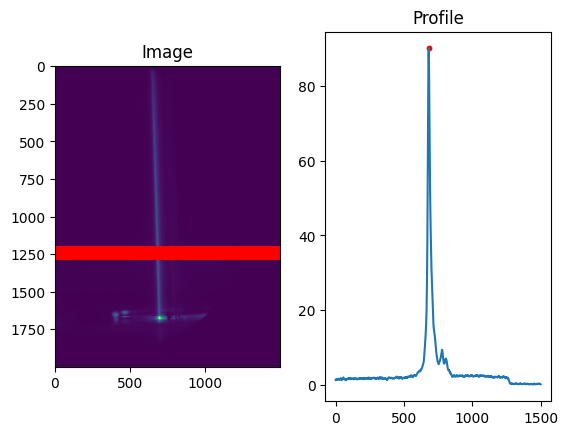

In [9]:

# Find peak 
x = np.linspace(0, img.shape[0], img.shape[0] )
peak  = smoothed_average_profile.max()
idx = np.where(smoothed_average_profile==peak)
x_peak =x[idx]
print(x_peak)
print(peak)

# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Image')
ax[0].imshow(img)
ax[0].plot([start[1], end[1]], [start[0], end[0]], 'r', linewidth= band)
ax[0].scatter(np.mean(x_peak), line , 30, c="k", marker="+") # plot markers
ax[1].set_title('Profile')
ax[1].plot(smoothed_average_profile)
ax[1].scatter(np.average(x_peak),peak, 10, c="r", marker="o" )




#### Gaussian fit and peak 

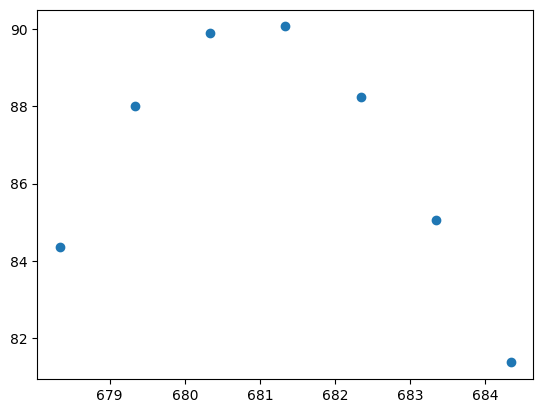

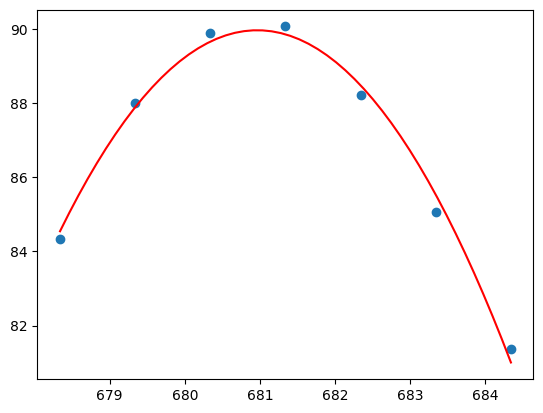

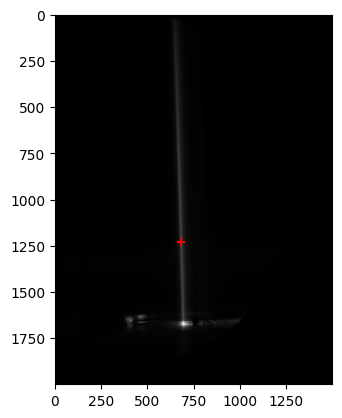

In [10]:

# Optimize parameters for a gaussian fit
def gauss_f(x,A,mu,sig):
    return A*np.exp(-(x-mu)**2/sig**2)

# Grab only the points that follow the bell curve of intensity profile  
range_width = 3

start_idx = idx[0][0] - range_width 
end_idx = idx[0][0] + range_width + 1

x_data = x[start_idx:end_idx]
y_data = smoothed_average_profile[start_idx:end_idx]
plt.scatter(x_data, y_data)
plt.show()

# Curve fit of intensity profile

fit = np.polyfit(x_data, y_data, 2)
f = np.poly1d(fit)
x_model = np.linspace(np.min(x_data), np.max(x_data))
y_model = f(x_model)

plt.scatter(x_data, y_data)
plt.plot(x_model, y_model, color='r')
plt.show()

# Stablish average peak of the curve

peak_mod = max(y_model)
idx = np.where(y_model==peak_mod)
x_avg = x_model[idx]


# Mark the peak on og picture
pyplot.imshow(img, cmap='gray')
plt.scatter(x_avg,line , 30, c="r", marker="+") # plot markers
plt.show()



"\nplt.scatter(x_data, y_data, c='r')\n"

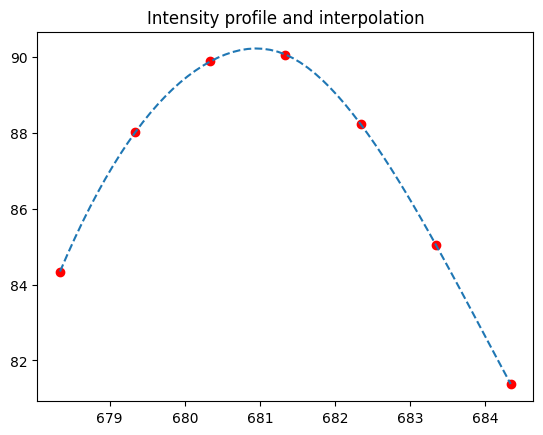

In [11]:
# Diferent fit for intensity profile

# Spline
'''
cs = CubicSpline(x_data, y_data)
x_range = np.arange(np.min(x_data),np.max(x_data))
plt.plot(x_range, cs(x_range), label='Cubic Spline')
'''
# Interpolation 
x_range = np.arange(np.min(x_data), np.max(x_data), 0.1) 
cubic =  interp1d(x_data, y_data, kind='cubic')
y_new = cubic(x_range)
plt.scatter(x_data, y_data, c='r')
plt.plot(x_range, y_new, '--')
plt.title('Intensity profile and interpolation')

# Grab 5 points from this interpolation and interpolate again -> 
 
'''
plt.scatter(x_data, y_data, c='r')
'''


#### Identify wall

C:\Users\valmu\AppData\Local\Temp\ipykernel_24816\1985460427.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  wall_ = int(wall_loc[0])


<class 'int'>
1677


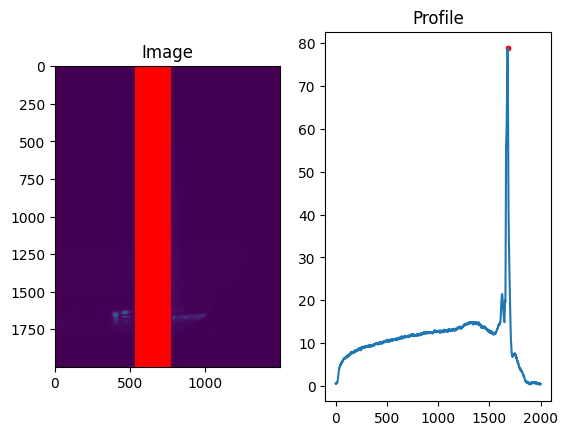

In [12]:
# Vertical loop to identify the wall 

width = img.shape[1]
height = img.shape[0]
ver = 650
thick = 260
lin_w = thick/10

start = (0 ,ver) #Start of the profile , col=0
end = ( height-1,ver ) #End of the profile line row=100, col=las
ver_profile = profile_line(img, start, end, linewidth = thick)
#ver_profile = img8_[:, ver] 

# Find peak 
wall = np.max(ver_profile)
wall_loc = np.where(ver_profile == wall)
wall_ = int(wall_loc[0])
print(type(wall_))
print((wall_))

fig, ax = plt.subplots(1, 2)
ax[0].set_title('Image')
ax[0].imshow(img)
ax[0].plot([start[1], end[1]], [start[0], end[0]], linewidth= lin_w, color = 'r') #linewidth=thick
ax[1].set_title('Profile')
ax[1].plot(ver_profile)
ax[1].scatter(np.average(wall_loc), wall ,10, c="r", marker="o" );

# The wall is gonn be the peak of intensity when we draw the profile vertically



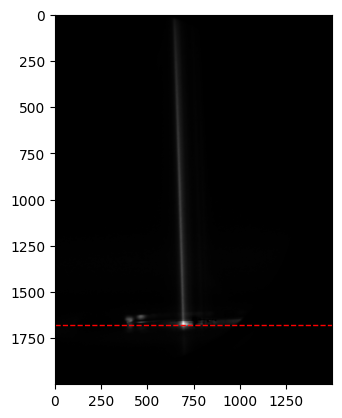

In [13]:
# Plotted line at the peak intensity, where the wall tentatively is
pyplot.imshow(img, cmap='gray')
plt.plot([0,width-1 ], [(wall_), (wall_)],'--',  linewidth= 1, color = 'r') #linewidth=thickplt.show

this may not be accurate since there was a mistake during experimennt, wall is not the real wall


#### Loop 

In [14]:
"""
# Loop for each row of pixels 

x_points = []
y_points = []

for i in np.range(0,min, 30):
  
    start = (i, 0) #Start of the profile , col=0
    end = (i, height- 1) #End of the profile line row=100, col=last
    profile = profile_line(img8, start, end)
    profile = img8[i,:] 
    # Find peak 
    peak  = profile.max()
    # Optimize parameters for a gaussian fit
    x = np.linspace(0, height, height)
    #print(x.size)
    def gauss_f(x,A,mu,sig):
        return A*np.exp(-(x-mu)**2/sig**2)

    # Grab only the points that follow the bell curve of intensity profile

    idx0 = np.where(profile>0) 
    #print(idx0)
    x_data = x[idx0]
    y_data = profile[idx0]
    

    # Get optimal parameters of the gaussian curve

    popt, pcov = curve_fit(gauss_f, x_data, y_data, p0=[peak,670,60])
    #print(popt)
    A_opt, mu_opt, sig_opt = popt
    x_model = np.linspace(np.min(x_data), np.max(x_data), height)
    y_model = gauss_f(x_model, A_opt, mu_opt, sig_opt)

    # Curve fit of intensity profile

    #plt.scatter(x_data, y_data)
    #plt.plot(x_model, y_model, color='r')
    #plt.show()

    # Stablish average peak of the curve

    peak_mod = max(y_model)
    x_mod = x_model[(np.where(y_model==peak_mod))]
    #print(f"Max value of intensity according to model: {peak_mod}")
    peaks = [peak_mod, peak]
    avg = np.mean(peaks) 
    #avg = avg.astype(int)
    #print(y_data.shape)
    idx = np.where(y_data==peak)
    x_avg = np.mean(x_data[idx])
    #print(f"The avg of the peaks is {avg}")

    # Extract points
    x_points.append(x_mod)
    y_points.append(i)
   
"""


'\n# Loop for each row of pixels \n\nx_points = []\ny_points = []\n\nfor i in np.range(0,min, 30):\n  \n    start = (i, 0) #Start of the profile , col=0\n    end = (i, height- 1) #End of the profile line row=100, col=last\n    profile = profile_line(img8, start, end)\n    profile = img8[i,:] \n    # Find peak \n    peak  = profile.max()\n    # Optimize parameters for a gaussian fit\n    x = np.linspace(0, height, height)\n    #print(x.size)\n    def gauss_f(x,A,mu,sig):\n        return A*np.exp(-(x-mu)**2/sig**2)\n\n    # Grab only the points that follow the bell curve of intensity profile\n\n    idx0 = np.where(profile>0) \n    #print(idx0)\n    x_data = x[idx0]\n    y_data = profile[idx0]\n    \n\n    # Get optimal parameters of the gaussian curve\n\n    popt, pcov = curve_fit(gauss_f, x_data, y_data, p0=[peak,670,60])\n    #print(popt)\n    A_opt, mu_opt, sig_opt = popt\n    x_model = np.linspace(np.min(x_data), np.max(x_data), height)\n    y_model = gauss_f(x_model, A_opt, mu_opt, 

##### Loop with averaging band 

[array([645.98532383]), array([647.00634459]), array([648.15699496]), array([649.18252022]), array([650.20804549]), array([651.34318034]), array([651.92376078]), array([652.82916596]), array([653.91475127]), array([654.67451084]), array([655.71555162]), array([656.57140726]), array([657.32215783]), array([658.32666208]), array([659.36169686]), array([660.23256751]), array([661.18852323]), array([661.86369823]), array([662.89923351]), array([663.65949358]), array([664.18551947]), array([665.58992353]), array([666.46029368]), array([667.31614932]), array([668.30213506]), array([669.1524852]), array([669.78762017]), array([670.89823051]), array([671.65899108]), array([672.64848032]), array([673.34918084]), array([673.92475628]), array([675.00533659]), array([675.89072175]), array([676.56089175]), array([677.62145205]), array([678.48181219]), array([679.07240263]), array([680.12745743]), array([680.52285272]), array([681.22355325]), array([682.42375315]), array([683.12445367]), array([683.

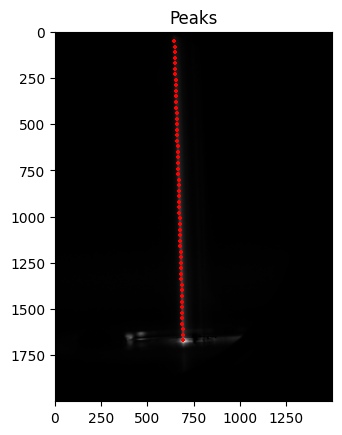

In [15]:
x_points = []
y_points = []
first = 50
band = 20
step = 30
range_width = 5 
for i in np.arange(first, wall_+ 1, step):

    # Average the profile line 
    profiles = []
    band = 5

    for offset in np.arange(0, band+ 1):
        start_row = i + offset
        end_row = i + offset
        start = (start_row, 0)
        end = (end_row, height - 1)
        profile = profile_line(img, start, end)
        profiles.append(profile)

    # Convert the list of profiles to a NumPy array for easy averaging
    profiles = np.array(profiles)


    # Compute the average profile
    average_profile = np.mean(profiles, axis=0)

    # Smooth the average profile
    smoothing_window = 10 

    smoothed_average_profile = uniform_filter1d(average_profile, size=smoothing_window)

    # Find peak 

    peak  = np.max(average_profile)
    idx = np.where(average_profile==peak)

    # Optimize parameters for a gaussian fist
    x = np.linspace(0, height, height)

    # Slice 
    start_idx = idx[0][0] - range_width 
    end_idx = idx[0][0] + range_width + 1

    x_data = x[start_idx:end_idx]
    y_data = average_profile[start_idx:end_idx]
    '''
    sort_arr = np.sort(average_profile)
    min_int = sort_arr[-range_width]
    idx0 = np.where(average_profile>min_int) 
    x_data = x[idx0]
    y_data = average_profile[idx0]
    '''


    # Subpixel location of peak through curve fit

    fit = np.polyfit(x_data, y_data, 2)
    f = np.poly1d(fit)
    x_model = np.linspace(np.min(x_data), np.max(x_data), height)
    y_model = f(x_model)


    # Stablish average peak of the curve
    peak_mod = np.max(y_model)
    x_mod = x_model[(np.where(y_model==peak_mod))]
    # Extract points
    x_points.append((x_mod))
    y_points.append(i)
    


print(x_points)
print(y_points)

# smoothered data display
# Plot the points on the image and as plot on itself 
pyplot.imshow(img, cmap='gray')
plt.scatter(x_points,y_points, 5, c="r", marker="+") ;# plot markers
#plt.plot(x_points,y_points, 5, c="r") ;# plot markers
plt.title("Peaks")
plt.show()


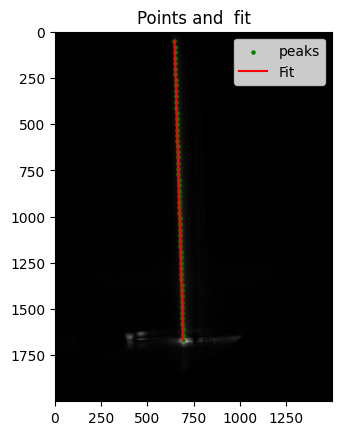

In [16]:
# First Pass
# Fitting the points obtained that way we get the closest to a straight line
degree = 1
# flatten xpoints 
x_points_flat = [x[0] for x in x_points]
x_points_flat = np.array(x_points_flat)

# Start fit 
z = np.polyfit( y_points, x_points_flat, degree)
fun = np.poly1d(z)
range = np.arange(np.min(y_points), np.max(y_points))

# Make them points
x_fit = fun(range)
y_fit = range

# Plot 
plt.imshow(img, cmap='gray')
plt.scatter(x_points, y_points,20,  label='peaks', color='green', marker='.')
plt.plot(x_fit,y_fit, label='Fit', color='r')
plt.legend()
plt.title('Points and  fit');


In [17]:
# 2nd pass
# Compare the guess of where the peaks are to the actual one and to do a better estimate to grab the points
x_2ndpass = []
y_2ndpass = []


# Functions for second pass
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


for i in np.arange(first, wall_+ 1, step):

    # Average the profile line 
    profiles = []
    band = 5

    for offset in np.arange(0, band+ 1):
        start_row = i + offset
        end_row = i + offset
        start = (start_row, 0)
        end = (end_row, height - 1)
        profile = profile_line(img, start, end)
        profiles.append(profile)

    # Convert the list of profiles to a NumPy array for easy averaging
    profiles = np.array(profiles)

    # Compute the average profile
    average_profile = np.mean(profiles, axis=0)

    # Smooth the average profile
    smoothing_window = 10 

    smoothed_average_profile = uniform_filter1d(average_profile, size=smoothing_window)


    # Locate where the curve fit value is in the intensity profile  
    
    x = np.linspace(0, height, height)

    x_fit = (fun(i))

    nearest_x = find_nearest(x, value=x_fit)

    
    idx_xfit = np.where(x == nearest_x)
    idx_xfit = idx_xfit [0][0]

    int_fit = average_profile[idx_xfit]

    # Define the range to grab values to the left and right of the peak on the fit

    range_width = 9# Number of elements to take to the left and right

    # Calculate the start and end indices for slicing

    start_idx = idx_xfit - range_width
    end_idx = idx_xfit + range_width + 1

    x_data = x[start_idx:end_idx]
    y_data = smoothed_average_profile[start_idx:end_idx]

    # Subpixel location of peak through curve fit

    fit = np.polyfit(x_data, y_data, 2)
    f = np.poly1d(fit)
    x_model = np.linspace(np.min(x_data), np.max(x_data), height)
    y_model = f(x_model)

    # Stablish average peak of the curve
    peak_mod = np.max(y_model)
    x_mod = x_model[(np.where(y_model==peak_mod))]
    # Extract points
    x_2ndpass.append((x_mod))
    y_2ndpass.append(i)


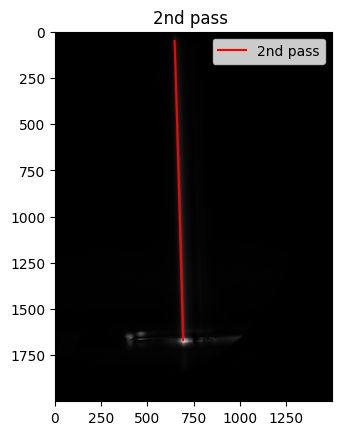

In [18]:

pyplot.imshow(img, cmap='gray')
plt.plot(x_2ndpass,y_2ndpass, c="r", label='2nd pass') ;# plot markers
#plt.plot(x_points, y_points, color='g', alpha=0.7)

plt.title("2nd pass ")
plt.legend()
plt.show()


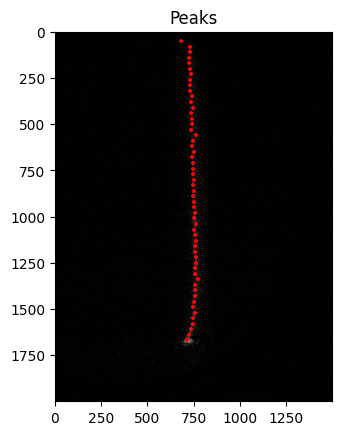

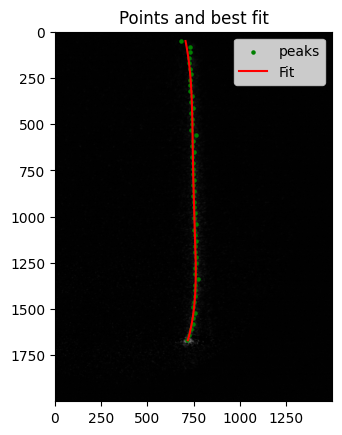

In [19]:
# Image 2 
width0 = img0.shape[1]
height0 = img0.shape[0]

x_points0 = []
y_points0 = []

# Wall detection
first = 50
band =20
range_width = 9
for i in np.arange(first, wall_+ 1, step):

    # Average the profile line 
    profiles = []
    band = 5

    for offset in np.arange(0, band+ 1):
        start_row = i + offset
        end_row = i + offset
        start = (start_row, 0)
        end = (end_row, height0 - 1)
        profile = profile_line(img0, start, end)
        profiles.append(profile)

    # Convert the list of profiles to a NumPy array for easy averaging
    profiles = np.array(profiles)


    # Compute the average profile
    average_profile = np.mean(profiles, axis=0)

    smoothing_window = 5 

    smoothed_average_profile = uniform_filter1d(average_profile, size=smoothing_window)

    # Find peak 
    peak  = np.max(average_profile)
    idx = np.where(average_profile==peak)

    # Optimize parameters for a gaussian fist
    x = np.linspace(0, height0, height0)
    def gauss_f(x,A,mu,sig):
        return A*np.exp(-(x-mu)**2/sig**2)
    

    '''
    # Grab only the points that follow the bell curve of intensity profile
    sort_arr = np.sort(average_profile)
    min_int = sort_arr[-6]
    idx0 = np.where(average_profile>min_int) 
    x_data = x[idx0]
    y_data = average_profile[idx0]
    '''

    # Slicing section 

    start_idx = max(idx[0][0] - range_width, 0)
    end_idx = idx[0][0] + range_width + 1

    x_data = x[start_idx:end_idx]
    y_data = average_profile[start_idx:end_idx]

    # Subpixel location of peak through curve fit

    fit = np.polyfit(x_data, y_data, 2)
    f = np.poly1d(fit)
    x_model = np.linspace(np.min(x_data), np.max(x_data), height0)
    y_model = f(x_model)

    '''
    popt, pcov = curve_fit(gauss_f, x_data, y_data, p0=[peak,650,100 ], maxfev = 1000)
    A_opt, mu_opt, sig_opt = popt
    x_model = np.linspace(np.min(x_data), np.max(x_data), height)
    y_model = gauss_f(x_model, A_opt, mu_opt, sig_opt)
    '''
    # Stablish average peak of the curve
    peak_mod = np.max(y_model)
    x_mod = x_model[(np.where(y_model==peak_mod))]
    # Extract points
    x_points0.append((x_mod))
    y_points0.append(i)
    

x_points0_flat = np.array([x[0] for x in x_points0])
x_points0_flat = np.array(x_points0_flat)    

pyplot.imshow(img0, cmap='gray')
plt.scatter(x_points0_flat,y_points0, 5, c="r", marker="+") ;# plot markers
plt.title("Peaks")
plt.show()

# Fit 
degree = 5
ini0 = 5
lim0 = 121
z = np.polyfit( y_points0, x_points0_flat, degree)
fun0 = np.poly1d(z)
range = np.arange(np.min(y_points0), np.max(y_points0))

# Plot 
pyplot.imshow(img0, cmap='gray')
plt.scatter(x_points0_flat, y_points0 ,20,  label='peaks', color='green', marker='.')
plt.plot(fun0(range),range, label='Fit', color='r')
plt.legend()
plt.title('Points and best fit');



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[647.15727763 647.185803   647.21432836 ... 693.28279134 693.3113167
 693.33984206]
[array([715.35767884]), array([718.06338387]), array([726.36318159]), array([727.59941752]), array([726.05187036]), array([731.13495217]), array([733.50532195]), array([725.36268134]), array([727.36368184]), array([729.36468234]), array([741.20301772]), array([731.36568284]), array([743.26708126]), array([738.09641189]), array([743.15997418]), array([742.82714143]), array([735.36768384]), array([746.95326653]), array([750.99881106]), array([736.36818409]), array([755.37768884]), array([737.36868434]), array([745.96377729]), array([745.85566921]), array([749.62193453]), array([751.48679893]), array([747.42423738]), array([759.37968984]), array([752.71352535]), array([752.89420598]), array([753.67849007]), array([756.10241339]), array([754.67949082]), array([764.35566458]), array([755.57238349]), array([757.38369435]), array([761.89770723]), array([751.37568784]), array([760.14195192]), array([761.9797892

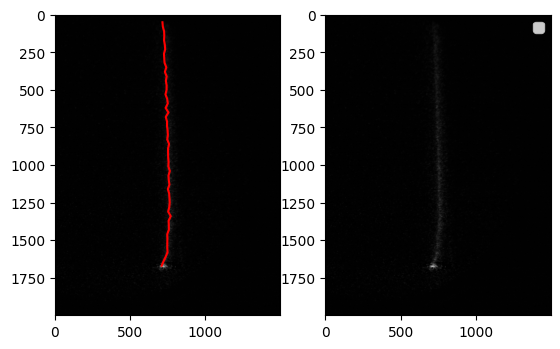

In [20]:
# 2nd Pass
x0_2ndpass = []
y0_2ndpass = []

range_width = 9 # Number of elements to take to the left and right


for i in np.arange(first, wall_+ 1, step):

    # Average the profile line 
    profiles = []
    band = 5

    for offset in np.arange(0, band+ 1):
        start_row = i + offset
        end_row = i + offset
        start = (start_row, 0)
        end = (end_row, height0 - 1)
        profile = profile_line(img0, start, end)
        profiles.append(profile)

    # Convert the list of profiles to a NumPy array for easy averaging
    profiles = np.array(profiles)

    # Compute the average profile
    average_profile = np.mean(profiles, axis=0)
    # Locate where the curve fit value is in the intensity profile  
    
    x = np.linspace(0, height0, height0)

    x_fit = (fun0(i))

    nearest_x = find_nearest(x, value=x_fit)

    
    idx_xfit = np.where(x == nearest_x)
    idx_xfit = idx_xfit [0][0]

    int_fit = average_profile[idx_xfit]

    # Calculate the start and end indices for slicing

    start_idx = max(idx_xfit - range_width, 0)
    end_idx = idx_xfit + range_width + 1

    x_data = x[start_idx:end_idx]
    y_data = average_profile[start_idx:end_idx]

    # Subpixel location of peak through curve fit

    fit = np.polyfit(x_data, y_data, 2)
    f = np.poly1d(fit)
    x_model = np.linspace(np.min(x_data), np.max(x_data), height)
    y_model = f(x_model)

    # Stablish average peak of the curve
    peak_mod = np.max(y_model)
    x_mod = x_model[(np.where(y_model==peak_mod))]
    # Extract points
    x0_2ndpass.append((x_mod))
    y0_2ndpass.append(i)


print(fun(range))
print(x0_2ndpass)

# Display plots 
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img0, cmap='gray')
ax[0].plot(x0_2ndpass,y0_2ndpass, c="r", label='2nd pass') ;# plot markers
ax[1].imshow(img0, cmap='gray')
plt.legend()
plt.show()


#### Analysis 

In [21]:
# Get the distance between the points, to finaly get the 
# substarct arrays ?
print(len(x_2ndpass))
print(len(x0_2ndpass))
x_delta = np.array(x0_2ndpass) - np.array(x_2ndpass)
y_delta = np.array(y_points0) - np.array(y_points0)
print(x_delta)

55
55
[[67.72320628]
 [69.36534801]
 [76.65563647]
 [76.99998073]
 [74.37986127]
 [78.59757793]
 [80.18366362]
 [71.19367588]
 [72.11309507]
 [73.38386552]
 [84.23121015]
 [73.46544708]
 [84.71769652]
 [78.51949987]
 [82.59157092]
 [81.43841806]
 [72.98746922]
 [83.98746647]
 [87.02350175]
 [71.58156367]
 [89.69867625]
 [70.59007242]
 [78.37385426]
 [77.45443507]
 [80.37385376]
 [81.38236202]
 [76.62560645]
 [87.53551363]
 [80.04002001]
 [79.33731748]
 [79.38286302]
 [81.13061033]
 [78.71619652]
 [87.48196009]
 [77.96844896]
 [78.79727758]
 [82.50898836]
 [71.28426645]
 [79.0950753 ]
 [80.46394383]
 [81.15763735]
 [77.37335401]
 [69.14763034]
 [85.37185051]
 [70.62410645]
 [71.08206429]
 [70.81079309]
 [59.25073592]
 [59.40188704]
 [57.72370928]
 [56.8203061 ]
 [58.18717263]
 [45.0845733 ]
 [29.66615874]
 [16.22021616]]


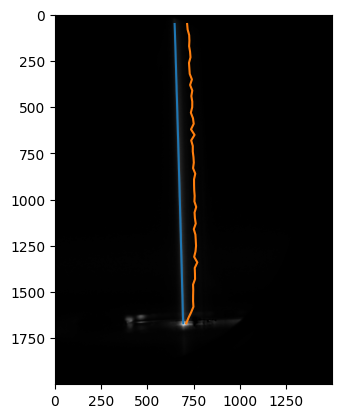

In [22]:
#Display both plots
plt.imshow(img, cmap='gray')
plt.plot(x_2ndpass, y_2ndpass)
plt.plot(x0_2ndpass, y0_2ndpass)


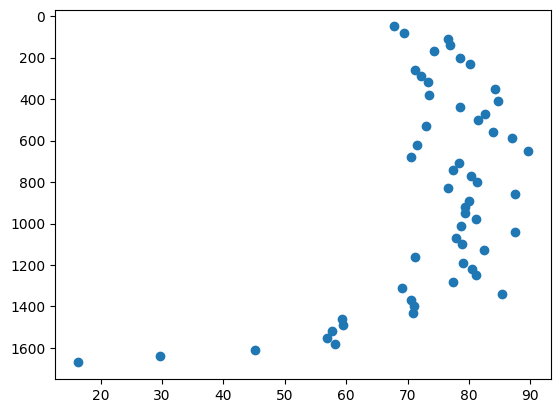

In [23]:
# Dsiplay the displacement vector
plot = plt.scatter(x_delta, y0_2ndpass)
ax = plot.axes
ax.invert_yaxis()

In [24]:
# Refine
x_delta_flat = np.array([x[0] for x in x_delta])
x_delta_flat = np.array(x_delta_flat)    
degree = 2

z = np.polyfit( y_2ndpass, x_delta_flat, degree)
fun1 = np.poly1d(z)
range = np.arange(np.min(y_2ndpass), np.max(y_2ndpass))
'''
plot = plt.scatter(x_delta_flat, y_2ndpass)
ax = plot.axes
ax.invert_yaxis()
plt.plot(fun1(range),range, label='Fit', color='r')
'''

"\nplot = plt.scatter(x_delta_flat, y_2ndpass)\nax = plot.axes\nax.invert_yaxis()\nplt.plot(fun1(range),range, label='Fit', color='r')\n"

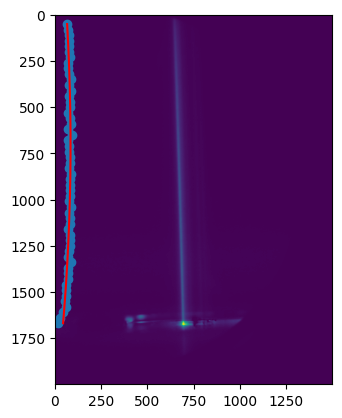

In [25]:
# try to make it that way it this starts from where the beam is in the image 

plt.imshow(img)
plt.scatter(x_delta_flat, y_2ndpass)
plt.plot(fun1(range),range, label='Fit', color='r')